In [136]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.impute import SimpleImputer

# Load the DataFrame from the CSV file
df = pd.read_csv("/Users/marclambertes/Python/Matches/Men/2024-2025/Eredivisie 2024-2025/PSV 1-1 Willem II.csv")

# Filter rows where TypeId is 3 (dribbles)
df_filtered = df[df['typeId'] == 3]

# We need to find the rows where Outcome is 1 and return the (x, y) coordinates for the next action.
df_filtered['Next_X'] = df_filtered['x'].shift(-1)
df_filtered['Next_Y'] = df_filtered['y'].shift(-1)

# Calculate distances for beginning and end of the dribble
df_filtered['beginning'] = np.sqrt(np.square(105 - df_filtered['x']) + np.square(52.5 - df_filtered['y']))
df_filtered['end'] = np.sqrt(np.square(105 - df_filtered['Next_X']) + np.square(52.5 - df_filtered['Next_Y']))

# Progressive movement check (whether the dribble was progressive)
df_filtered['progressive'] = [
    (df_filtered['end'].iloc[x]) / (df_filtered['beginning'].iloc[x]) < .75
    for x in range(len(df_filtered))
]

# Load the xT grid (Expected Threat grid)
xT = pd.read_csv("xT_grid.csv", header=None)
xT = np.array(xT)
xT_rows, xT_cols = xT.shape

# Remove rows with missing coordinates
df_filtered = df_filtered.dropna(subset=['x', 'y', 'Next_X', 'Next_Y'])

# Ensure coordinate columns are numeric
for col in ['x', 'y', 'Next_X', 'Next_Y']:
    df_filtered[col] = pd.to_numeric(df_filtered[col], errors='coerce')

# Drop rows with missing or invalid coordinates
df_filtered.dropna(subset=['x', 'y', 'Next_X', 'Next_Y'], inplace=True)

# Assign bins for x and y coordinates for xT
df_filtered['x1_bin'] = pd.cut(df_filtered['x'], bins=xT_cols, labels=False)
df_filtered['y1_bin'] = pd.cut(df_filtered['y'], bins=xT_rows, labels=False)
df_filtered['x2_bin'] = pd.cut(df_filtered['Next_X'], bins=xT_cols, labels=False)
df_filtered['y2_bin'] = pd.cut(df_filtered['Next_Y'], bins=xT_rows, labels=False)

# Apply lambda function to access xT values
df_filtered['start_zone_value'] = df_filtered[['x1_bin', 'y1_bin']].apply(lambda x: xT[x[1], x[0]] if x[1] >= 0 and x[0] >= 0 else np.nan, axis=1)
df_filtered['end_zone_value'] = df_filtered[['x2_bin', 'y2_bin']].apply(lambda x: xT[x[1], x[0]] if x[1] >= 0 and x[0] >= 0 else np.nan, axis=1)

# Remove rows with NaN zone values
df_filtered = df_filtered.dropna(subset=['start_zone_value', 'end_zone_value'])

# Calculate xT (Expected Threat) value for the dribble action
df_filtered['xT'] = df_filtered['end_zone_value'] - df_filtered['start_zone_value']

# --- Start EPV Handling ---
# Import EPV grid (Expected Possession Value)
epv = pd.read_csv("epv_grid.csv", header=None)  # Assuming epv_grid.csv was saved earlier
epv = np.array(epv)  # Convert to numpy array
epv_rows, epv_cols = epv.shape  # Get rows and columns

# Ensure coordinate columns are numeric (again)
df_filtered['x'] = pd.to_numeric(df_filtered['x'], errors='coerce')
df_filtered['y'] = pd.to_numeric(df_filtered['y'], errors='coerce')
df_filtered['Next_X'] = pd.to_numeric(df_filtered['Next_X'], errors='coerce')
df_filtered['Next_Y'] = pd.to_numeric(df_filtered['Next_Y'], errors='coerce')

# Assign bins for x and y coordinates for EPV
df_filtered['x1_bin'] = pd.cut(df_filtered['x'], bins=epv_cols, labels=False).astype('Int64')
df_filtered['y1_bin'] = pd.cut(df_filtered['y'], bins=epv_rows, labels=False).astype('Int64')
df_filtered['x2_bin'] = pd.cut(df_filtered['Next_X'], bins=epv_cols, labels=False).astype('Int64')
df_filtered['y2_bin'] = pd.cut(df_filtered['Next_Y'], bins=epv_rows, labels=False).astype('Int64')

# Apply EPV values based on the coordinate bins
def get_epv_value(bin_indices, epv_grid):
    if pd.notnull(bin_indices[0]) and pd.notnull(bin_indices[1]):
        return epv_grid[int(bin_indices[1])][int(bin_indices[0])]
    return np.nan  # Return NaN if indices are invalid

df_filtered['start_zone_value_epv'] = df_filtered[['x1_bin', 'y1_bin']].apply(lambda x: get_epv_value(x, epv), axis=1)
df_filtered['end_zone_value_epv'] = df_filtered[['x2_bin', 'y2_bin']].apply(lambda x: get_epv_value(x, epv), axis=1)

# Ensure the EPV values are numeric
df_filtered['start_zone_value_epv'] = pd.to_numeric(df_filtered['start_zone_value_epv'], errors='coerce')
df_filtered['end_zone_value_epv'] = pd.to_numeric(df_filtered['end_zone_value_epv'], errors='coerce')

# Clip the EPV values to ensure they are no greater than 1
df_filtered['start_zone_value_epv'] = df_filtered['start_zone_value_epv'].clip(0, 1)
df_filtered['end_zone_value_epv'] = df_filtered['end_zone_value_epv'].clip(0, 1)

# Compute EPV (Expected Possession Value) for the action
df_filtered['epv'] = df_filtered['end_zone_value_epv'] - df_filtered['start_zone_value_epv']

# --- Look-Ahead for Shot (xShot) ---
# Define the target variable for xShot: whether the dribble leads to a shot in the next 5 actions
def look_ahead_for_shot(index, max_lookahead=5):
    shot_types = [13, 14, 15, 16]  # Shot types
    if index + max_lookahead < len(df):  # Ensure there are enough future actions
        return df.iloc[index + 1:index + max_lookahead + 1]['typeId'].isin(shot_types).any()
    return False

# Apply the function to check if a dribble leads to a shot in the next actions
df_filtered['leads_to_shot'] = df_filtered.index.to_series().apply(look_ahead_for_shot)

# Target variable for xShot: 1 if the dribble leads to a shot, 0 otherwise
df_filtered['xShot'] = df_filtered['leads_to_shot'].astype(int)

# --- xDribble Target Variable ---
# Assuming 'outcome' is the target for whether the dribble was successful (1) or unsuccessful (0)
df_filtered['xDribble'] = df_filtered['outcome']

# Check if both classes (0 and 1) are present for both xShot and xDribble
print("Class distribution for xShot:")
print(df_filtered['xShot'].value_counts())

print("Class distribution for xDribble:")
print(df_filtered['xDribble'].value_counts())

# --- xShot Model ---
X_shot = df_filtered[['beginning', 'end', 'xT', 'epv', 'progressive']]

# Impute missing values for X_shot features
imputer = SimpleImputer(strategy='mean')
X_shot_imputed = imputer.fit_transform(X_shot)

y_shot = df_filtered['xShot']

X_train_shot, X_test_shot, y_train_shot, y_test_shot = train_test_split(X_shot_imputed, y_shot, test_size=0.2, random_state=42)

model_shot = LogisticRegression(solver='liblinear')
model_shot.fit(X_train_shot, y_train_shot)

y_pred_shot = model_shot.predict(X_test_shot)
accuracy_shot = accuracy_score(y_test_shot, y_pred_shot)
print(f"xShot Accuracy: {accuracy_shot:.4f}")
print(classification_report(y_test_shot, y_pred_shot))

y_proba_shot = model_shot.predict_proba(X_shot_imputed)[:, 1]
y_proba_shot = np.clip(y_proba_shot, 0, 1)
y_proba_shot = np.round(y_proba_shot, 2)

df_filtered['xShot'] = y_proba_shot

# --- xDribble Model ---
X_dribble = df_filtered[['beginning', 'end', 'xT', 'epv', 'progressive']]

# Impute missing values for X_dribble features
X_dribble_imputed = imputer.fit_transform(X_dribble)

y_dribble = df_filtered['xDribble']

X_train_dribble, X_test_dribble, y_train_dribble, y_test_dribble = train_test_split(X_dribble_imputed, y_dribble, test_size=0.2, random_state=42)

model_dribble = LogisticRegression(solver='liblinear')
model_dribble.fit(X_train_dribble, y_train_dribble)

y_pred_dribble = model_dribble.predict(X_test_dribble)
accuracy_dribble = accuracy_score(y_test_dribble, y_pred_dribble)
print(f"xDribble Accuracy: {accuracy_dribble:.4f}")
print(classification_report(y_test_dribble, y_pred_dribble))

y_proba_dribble = model_dribble.predict_proba(X_dribble_imputed)[:, 1]
y_proba_dribble = np.clip(y_proba_dribble, 0, 1)
y_proba_dribble = np.round(y_proba_dribble, 2)

df_filtered['xDribble'] = y_proba_dribble

# Load the team mapping file
mapping_file_path = '/Users/marclambertes/Downloads/opta_club_rankings_19012025.xlsx'  # Replace with your mapping file path
mapping_df = pd.read_excel(mapping_file_path)  # Assuming it has columns 'id' and 'team'

# Create a dictionary to map 'id' to 'team'
id_to_team = dict(zip(mapping_df['id'], mapping_df['team']))

# Add the team names to the df_filtered DataFrame based on player IDs
df_filtered['team'] = df_filtered['contestantId'].map(id_to_team)

# Save the filtered DataFrame to an Excel file
output_file = "dribbles_output_with_teams.xlsx"
df_filtered.to_excel(output_file, index=False)

# Display the result with the new columns
print(df_filtered[['playerName', 'team', 'x', 'y', 'Next_X', 'Next_Y', 'progressive', 'xT', 'epv', 'xShot', 'xDribble']])


/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_21127/2995247493.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Next_X'] = df_filtered['x'].shift(-1)
/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_21127/2995247493.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Next_Y'] = df_filtered['y'].shift(-1)
/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_21127/2995247493.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

Class distribution for xShot:
0    33
1     2
Name: xShot, dtype: int64
Class distribution for xDribble:
1    18
0    17
Name: xDribble, dtype: int64
xShot Accuracy: 1.0000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         7

    accuracy                           1.00         7
   macro avg       1.00      1.00      1.00         7
weighted avg       1.00      1.00      1.00         7

xDribble Accuracy: 0.4286
              precision    recall  f1-score   support

           0       0.33      0.33      0.33         3
           1       0.50      0.50      0.50         4

    accuracy                           0.43         7
   macro avg       0.42      0.42      0.42         7
weighted avg       0.43      0.43      0.43         7

        playerName       team     x     y  Next_X  Next_Y  progressive  \
26         N. Lang        PSV  41.8  95.4    58.5    91.6        False   
28         N. Lang        PSV  58.5  91.6    75.7    

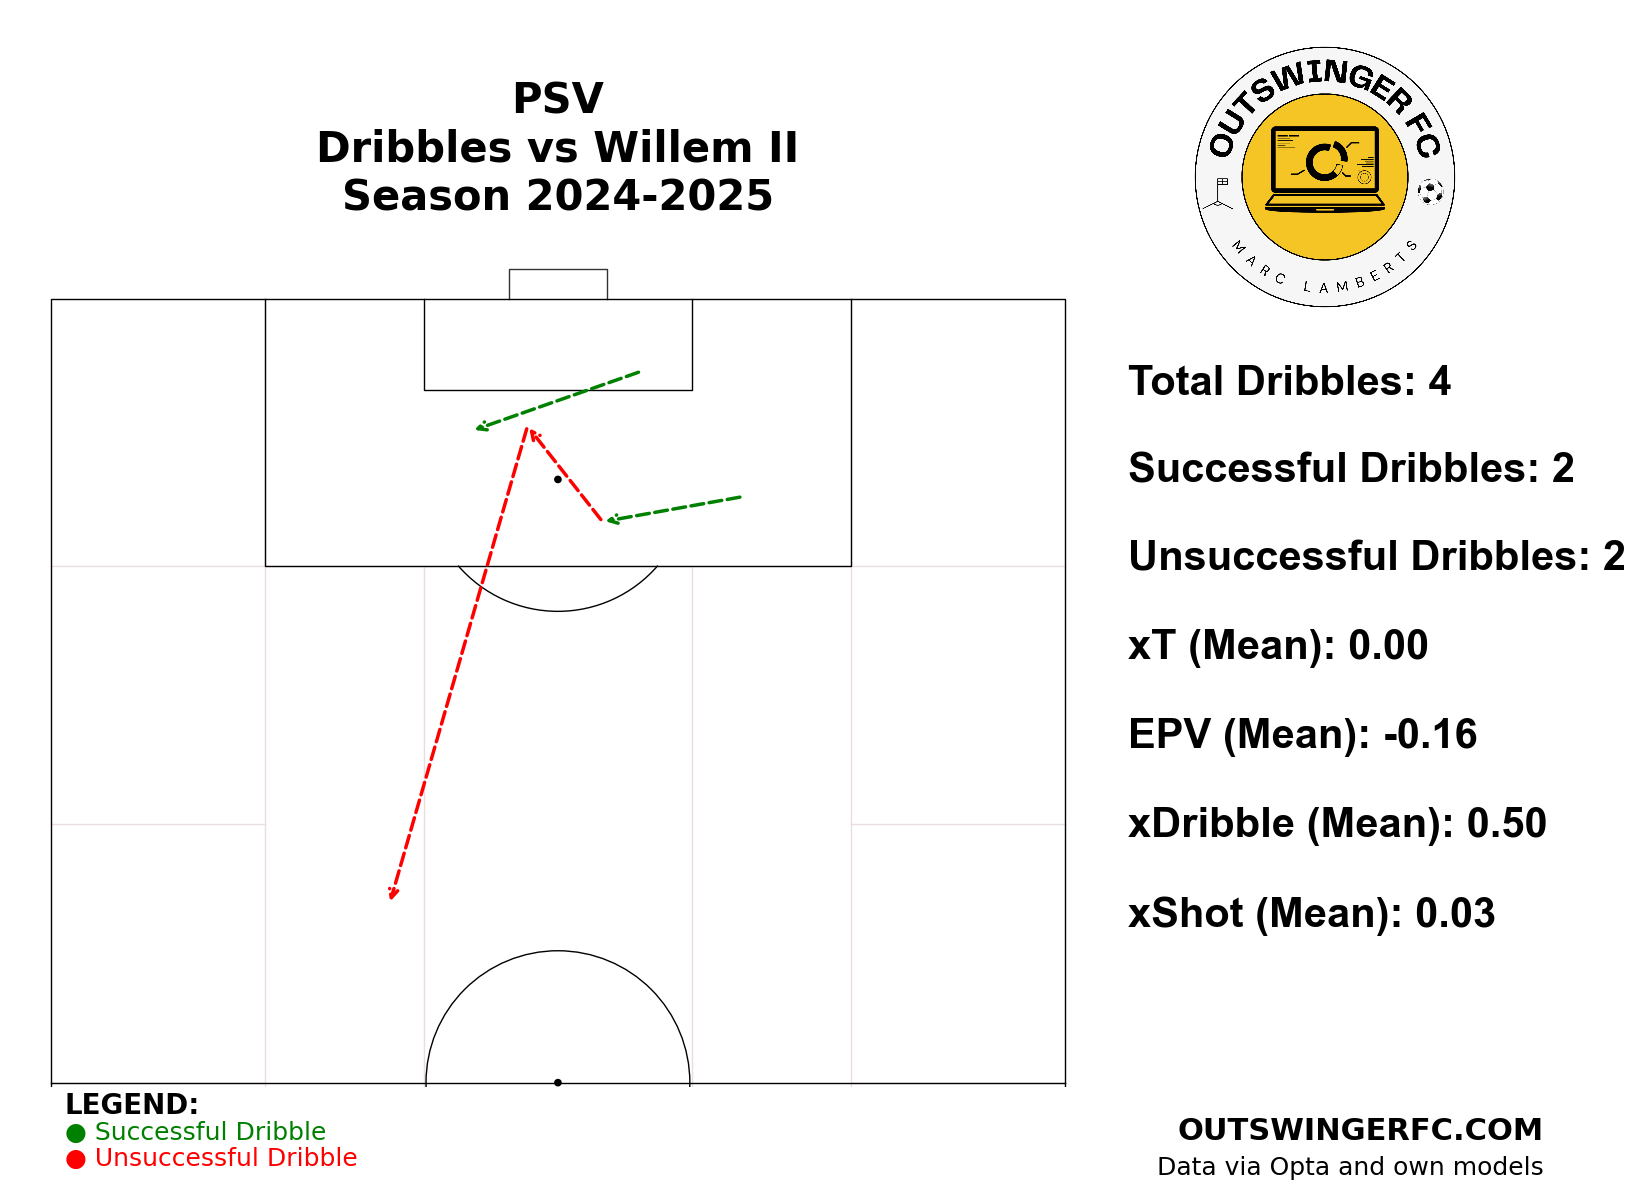

In [139]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mplsoccer.pitch import VerticalPitch
from matplotlib.patches import FancyArrowPatch
from matplotlib.offsetbox import OffsetImage, AnnotationBbox


df_filtered = pd.read_excel("dribbles_output_with_teams.xlsx")

# Filter for Chelsea dribbles only
df_filtered = df_filtered[df_filtered['team'] == 'PSV']

# Ensure no NaN values in coordinates
df_filtered.dropna(subset=['x', 'y', 'Next_X', 'Next_Y'], inplace=True)
df_filtered = df_filtered[(df_filtered['y'] >= 50) & (df_filtered['Next_Y'] >= 50)]


# Set up the pitch for a custom half-view ending at x=47.5
pitch = VerticalPitch(positional=True, pitch_type='opta', pitch_color='white', line_color='black',
                       linewidth=1, half=True, goal_type='box', goal_alpha=0.8)
fig, ax = pitch.draw(figsize=(18, 12))

# Manually limit the x-axis to 47.5
ax.set_ylim(49.7, 105)


# Calculate relevant stats
total_dribbles = len(df_filtered)
successful_dribbles = df_filtered[df_filtered['outcome'] == 1].shape[0]
unsuccessful_dribbles = df_filtered[df_filtered['outcome'] == 0].shape[0]

# Calculate the mean or total of xT, EPV, xDribble, and xShot
mean_xt = df_filtered['xT'].mean() if not df_filtered.empty else 0
mean_epv = df_filtered['epv'].mean() if not df_filtered.empty else 0
mean_xdribble = df_filtered['xDribble'].mean() if not df_filtered.empty else 0
mean_xshot = df_filtered['xShot'].mean() if not df_filtered.empty else 0

# Plot dribbles, using different colors for successful (green) and unsuccessful (red)
for i, row in df_filtered.iterrows():
    color = 'green' if row['outcome'] == 1 else 'red'
    
    # Create the arrow with arrowheads (FancyArrowPatch)
    arrow = FancyArrowPatch(
        (row['x'], row['y']), 
        (row['Next_X'], row['Next_Y']),
        mutation_scale=15,  # Size of the arrowhead
        color=color, 
        linewidth=2.5, 
        linestyle='--',  # Dashed line style
        arrowstyle='->',  # Arrowhead style
        zorder=2
    )
    ax.add_patch(arrow)

# Add statistics to the plot (successful vs. unsuccessful dribbles, xT, EPV, xDribble, xShot)
stats_text = (f"Total Dribbles: {total_dribbles}\n\n"
              f"Successful Dribbles: {successful_dribbles}\n\n"
              f"Unsuccessful Dribbles: {unsuccessful_dribbles}\n\n"
              f"xT (Mean): {mean_xt:.2f}\n\n"
              f"EPV (Mean): {mean_epv:.2f}\n\n"
              f"xDribble (Mean): {mean_xdribble:.2f}\n\n"
              f"xShot (Mean): {mean_xshot:.2f}\n")

# Add stats to the plot at a defined position
ax.text(1.02, 0.48, stats_text, transform=ax.transAxes, fontsize=30, 
        verticalalignment='center', fontweight='bold', color='black', fontfamily="Arial", linespacing=1.2)

# Optionally, add a legend explaining colors
legend_x = 0.05
legend_y = -0.03
ax.text(legend_x, legend_y, "LEGEND:", transform=ax.transAxes, fontsize=20, fontweight='bold', color='black', ha='left')
ax.text(legend_x, legend_y - 0.03, "● Successful Dribble", transform=ax.transAxes, fontsize=18, color='green', ha='left')
ax.text(legend_x, legend_y - 0.06, "● Unsuccessful Dribble", transform=ax.transAxes, fontsize=18, color='red', ha='left')

# Add logo in the bottom left corner
logo = plt.imread("/Users/marclambertes/Downloads/Outswinger FC (3).png")
imagebox = OffsetImage(logo, zoom=0.15)
ab = AnnotationBbox(imagebox, (1.2, 1.05), frameon=False, xycoords='figure fraction', boxcoords="axes fraction")
ax.add_artist(ab)

# Set face color and title
fig.set_facecolor('white')
ax.set_title("PSV\nDribbles vs Willem II\nSeason 2024-2025", fontsize=30, color="black", fontweight='bold', pad=8)

# Add right bottom text: OUTSWINGERF.COM (bold) & "Data via Opta and own models" (smaller)
ax.text(1.4, -0.06, "OUTSWINGERFC.COM", transform=ax.transAxes, fontsize=22, fontweight='bold', color='black', ha='right')
ax.text(1.4, -0.10, "Data via Opta and own models", transform=ax.transAxes, fontsize=18, color='black', ha='right')
#ax.invert_yaxis()

# Save the plot as an image (optional)
plt.savefig('Dribble_Outcomes_Visualization_Chelsea_Custom_Pitch.png', dpi=500, bbox_inches='tight', facecolor='white')

# Show the plot
plt.show()
